In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

In [36]:
# Ajouter le chemin du dossier parent (si besoin d'importer ScheduleEnv)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from environment.schedule_env import ScheduleEnv

In [37]:
# 1. Chargement des données
df = pd.read_csv("../Data/processed/cleaned_data.csv")


In [38]:
# 2. Initialiser l'environnement
env = ScheduleEnv(data_path="../Data/processed/cleaned_data.csv")

Erreur lors du chargement des données: "['TUCASEID', 'TUACTIVITY_N', 'TUSTARTTIM', 'ACTIVITY_NAME', 'TUDIARYDAY'] not in index"


In [39]:
# Calculer la taille de l'état
n_activities = len(env.activity_types)
state_size = env.n_time_slots * n_activities + env.days_of_week + 1  # schedule + day_of_week + time_remaining
action_size = env.action_space.nvec[0] * env.action_space.nvec[1]  # Nombre total d'actions possibles


In [40]:
print(f"\n✅ Environnement créé avec {action_size} actions possibles")


✅ Environnement créé avec 240 actions possibles


In [41]:
# 3. Paramètres du DQN
memory = deque(maxlen=2000)
batch_size = 32
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

In [42]:
# 4. Création du modèle DQN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_dim=state_size, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))

# Création du modèle cible
target_model = tf.keras.models.clone_model(model)
target_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.001))
target_model.set_weights(model.get_weights())

c:\Users\Abdel\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# 5. Fonction pour mettre à jour les graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.ion()

In [44]:
def update_plots(rewards, mean_rewards, epsilons, losses):
    ax1.clear()
    ax2.clear()
    
    ax1.plot(rewards, label='Récompense par épisode', alpha=0.4)
    ax1.plot(mean_rewards, label='Moyenne glissante (20)', color='red')
    ax1.set_title('Évolution des récompenses')
    ax1.set_xlabel('Épisode')
    ax1.set_ylabel('Récompense')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epsilons, label='Epsilon', color='green')
    if losses:
        ax2.plot(losses, label='Perte (Loss)', color='orange')
    ax2.set_title("Évolution de l'epsilon et des pertes")
    ax2.set_xlabel("Épisode")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)


In [45]:
# 6. Entraînement du DQN
def train_dqn(episodes=300):
    global epsilon
    rewards_history = []
    epsilons = []
    mean_rewards = []
    loss_history = []

    progress_bar = tqdm(range(episodes), desc="🔁 Entraînement DQN", unit="episode")

    for episode in progress_bar:
        state = env.reset()
        state_flat = np.concatenate([state['schedule'].flatten(), state['day_of_week'], state['time_remaining']])
        state = np.reshape(state_flat, [1, state_size])
        total_reward = 0
        done = False
        episode_loss = []

        while not done:
            if np.random.rand() <= epsilon:
                action = env.action_space.sample()
                action_idx = action[0] * env.n_time_slots + action[1]
            else:
                q_values = model.predict(state, verbose=0)[0]
                action_idx = np.argmax(q_values)
                action = np.array([action_idx // env.n_time_slots, action_idx % env.n_time_slots])

            next_state, reward, done, _ = env.step(action)
            next_state_flat = np.concatenate([
                next_state['schedule'].flatten(), 
                next_state['day_of_week'], 
                next_state['time_remaining']
            ])
            next_state = np.reshape(next_state_flat, [1, state_size])

            memory.append((state, action_idx, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) >= batch_size:
                minibatch = random.sample(memory, batch_size)
                states = np.array([x[0][0] for x in minibatch])
                actions = np.array([x[1] for x in minibatch])
                rewards_batch = np.array([x[2] for x in minibatch])
                next_states = np.array([x[3][0] for x in minibatch])
                dones = np.array([x[4] for x in minibatch])

                targets = model.predict(states, verbose=0)
                next_q_values = target_model.predict(next_states, verbose=0)

                for i in range(batch_size):
                    if dones[i]:
                        targets[i][actions[i]] = rewards_batch[i]
                    else:
                        targets[i][actions[i]] = rewards_batch[i] + gamma * np.max(next_q_values[i])

                history = model.fit(states, targets, epochs=1, verbose=0)
                episode_loss.append(history.history['loss'][0])

        if episode % 10 == 0:
            target_model.set_weights(model.get_weights())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_history.append(total_reward)
        epsilons.append(epsilon)
        loss_history.append(np.mean(episode_loss) if episode_loss else 0)

        window_size = 20
        if episode >= window_size:
            mean_rewards.append(np.mean(rewards_history[-window_size:]))
        else:
            mean_rewards.append(np.mean(rewards_history))

        progress_bar.set_postfix({
            'Reward': f"{total_reward:.1f}",
            'Epsilon': f"{epsilon:.2f}",
            'AvgReward': f"{mean_rewards[-1]:.1f}",
            'Loss': f"{loss_history[-1]:.4f}" if episode_loss else "N/A"
        })

        if episode % 10 == 0:
            update_plots(rewards_history, mean_rewards, epsilons, loss_history)

    plt.ioff()
    plt.show()
    return rewards_history, mean_rewards, loss_history



🚀 Début de l'entraînement...


🔁 Entraînement DQN:   0%|          | 0/300 [00:00<?, ?episode/s, Reward=3.8, Epsilon=0.99, AvgReward=3.8, Loss=N/A]

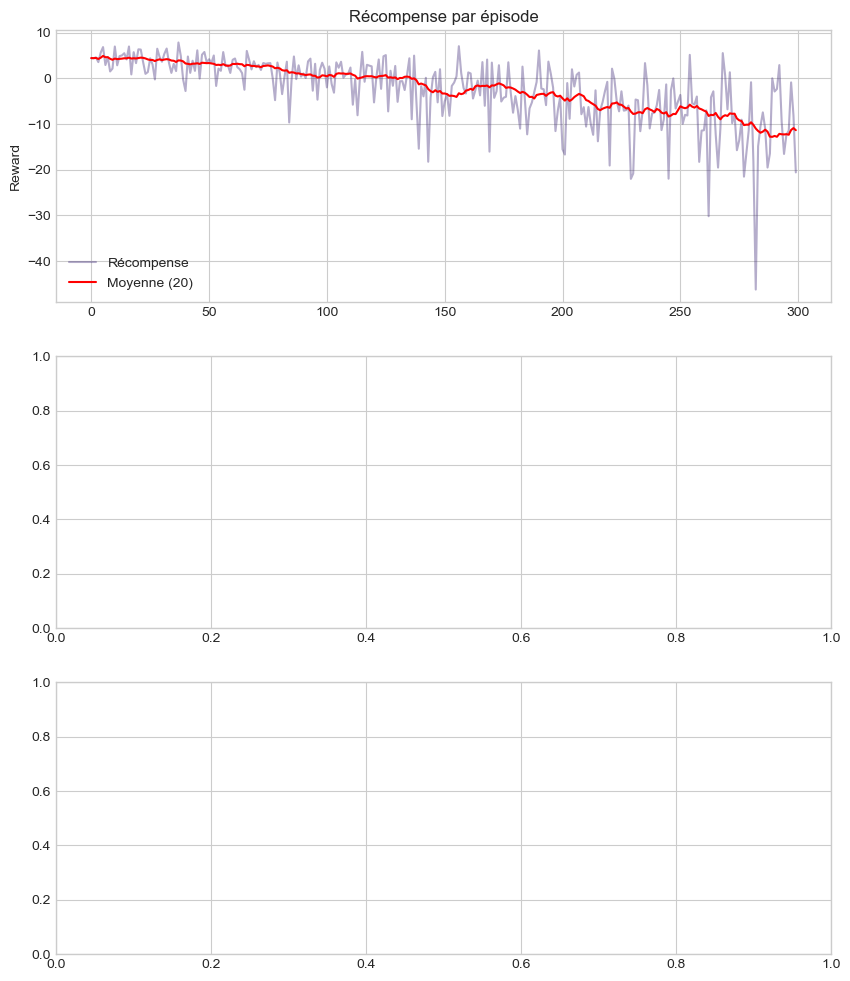

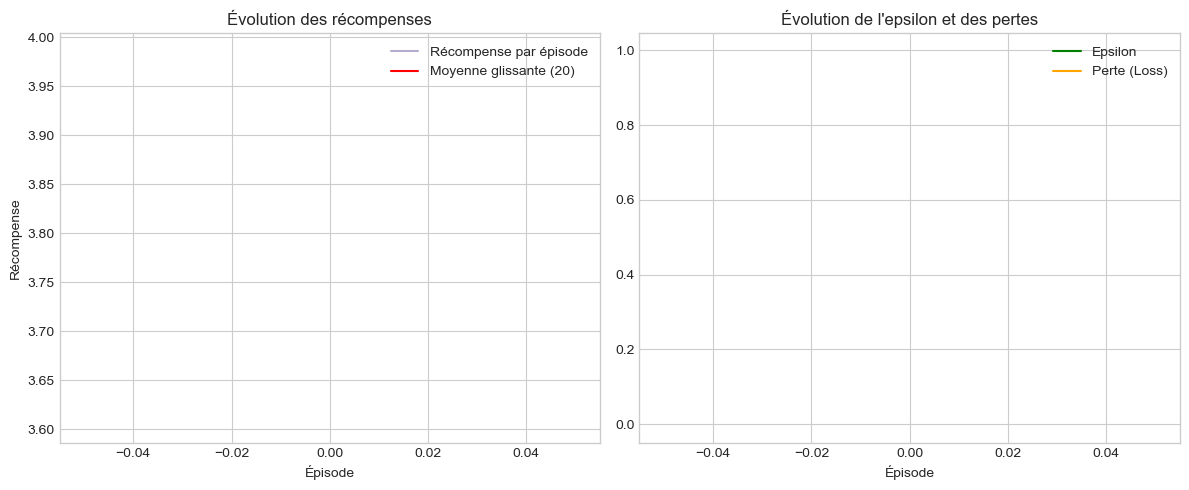

🔁 Entraînement DQN:   3%|▎         | 10/300 [00:23<11:30,  2.38s/episode, Reward=4.7, Epsilon=0.95, AvgReward=4.6, Loss=0.0017]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:   7%|▋         | 20/300 [00:48<10:58,  2.35s/episode, Reward=0.8, Epsilon=0.90, AvgReward=4.8, Loss=0.0020]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  10%|█         | 30/300 [01:14<11:17,  2.51s/episode, Reward=4.5, Epsilon=0.86, AvgReward=4.6, Loss=0.0019]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  13%|█▎        | 40/300 [01:39<10:54,  2.52s/episode, Reward=4.6, Epsilon=0.81, AvgReward=4.4, Loss=0.0027]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  17%|█▋        | 50/300 [02:06<11:18,  2.72s/episode, Reward=8.4, Epsilon=0.77, AvgReward=4.1, Loss=0.0020]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  20%|██        | 60/300 [02:34<11:20,  2.83s/episode, Reward=7.8, Epsilon=0.74, AvgReward=3.5, Loss=0.0018]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  23%|██▎       | 70/300 [03:05<11:33,  3.02s/episode, Reward=-1.0, Epsilon=0.70, AvgReward=2.5, Loss=0.0017]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  27%|██▋       | 80/300 [03:34<10:28,  2.86s/episode, Reward=2.6, Epsilon=0.67, AvgReward=2.4, Loss=0.0017] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  30%|███       | 90/300 [04:06<12:25,  3.55s/episode, Reward=3.8, Epsilon=0.63, AvgReward=2.3, Loss=0.0028] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  33%|███▎      | 100/300 [05:03<27:53,  8.37s/episode, Reward=3.1, Epsilon=0.60, AvgReward=1.7, Loss=0.0017] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  37%|███▋      | 110/300 [06:28<24:59,  7.89s/episode, Reward=-1.5, Epsilon=0.57, AvgReward=1.1, Loss=0.0013]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  40%|████      | 120/300 [08:04<32:52, 10.96s/episode, Reward=2.2, Epsilon=0.55, AvgReward=-0.9, Loss=0.0016]  

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  43%|████▎     | 130/300 [09:42<26:03,  9.20s/episode, Reward=-1.3, Epsilon=0.52, AvgReward=-1.5, Loss=0.0017]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  47%|████▋     | 140/300 [11:06<19:44,  7.40s/episode, Reward=0.3, Epsilon=0.49, AvgReward=-0.2, Loss=0.0015]  

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  50%|█████     | 150/300 [12:36<22:53,  9.15s/episode, Reward=-5.5, Epsilon=0.47, AvgReward=-0.2, Loss=0.0015]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  53%|█████▎    | 160/300 [14:34<24:55, 10.68s/episode, Reward=-15.5, Epsilon=0.45, AvgReward=-3.1, Loss=0.0017]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  57%|█████▋    | 170/300 [16:22<22:51, 10.55s/episode, Reward=-8.7, Epsilon=0.42, AvgReward=-4.3, Loss=0.0017] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  60%|██████    | 180/300 [18:21<23:13, 11.62s/episode, Reward=-3.9, Epsilon=0.40, AvgReward=-4.4, Loss=0.0016] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  63%|██████▎   | 190/300 [20:21<21:25, 11.68s/episode, Reward=0.3, Epsilon=0.38, AvgReward=-5.7, Loss=0.0011]  

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  67%|██████▋   | 200/300 [21:27<08:52,  5.32s/episode, Reward=-8.2, Epsilon=0.37, AvgReward=-4.1, Loss=0.0011]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  70%|███████   | 210/300 [22:21<08:01,  5.35s/episode, Reward=0.5, Epsilon=0.35, AvgReward=-2.5, Loss=0.0013] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  73%|███████▎  | 220/300 [23:26<08:04,  6.06s/episode, Reward=-13.0, Epsilon=0.33, AvgReward=-4.9, Loss=0.0007]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  77%|███████▋  | 230/300 [24:24<07:29,  6.41s/episode, Reward=0.8, Epsilon=0.31, AvgReward=-5.8, Loss=0.0006]  

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  80%|████████  | 240/300 [25:27<05:26,  5.43s/episode, Reward=-1.5, Epsilon=0.30, AvgReward=-5.0, Loss=0.0004] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  83%|████████▎ | 250/300 [26:39<06:58,  8.38s/episode, Reward=-5.1, Epsilon=0.28, AvgReward=-6.6, Loss=0.0003] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  87%|████████▋ | 260/300 [27:50<04:38,  6.97s/episode, Reward=-14.7, Epsilon=0.27, AvgReward=-7.7, Loss=0.0003]

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  90%|█████████ | 270/300 [29:04<04:05,  8.19s/episode, Reward=1.8, Epsilon=0.26, AvgReward=-8.2, Loss=0.0003]  

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  93%|█████████▎| 280/300 [30:31<02:19,  6.98s/episode, Reward=-22.4, Epsilon=0.24, AvgReward=-9.9, Loss=0.0002] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN:  97%|█████████▋| 290/300 [32:00<01:20,  8.08s/episode, Reward=-9.0, Epsilon=0.23, AvgReward=-10.8, Loss=0.0002] 

<Figure size 640x480 with 0 Axes>

🔁 Entraînement DQN: 100%|██████████| 300/300 [33:08<00:00,  6.63s/episode, Reward=1.4, Epsilon=0.22, AvgReward=-10.4, Loss=0.0002]  


In [46]:
# 7. Lancer l'entraînement
print("\n🚀 Début de l'entraînement...")
rewards, avg_rewards, losses = train_dqn(episodes=300)


In [47]:
# 8. Sauvegarde du modèle
os.makedirs("../models", exist_ok=True)
model.save("../models/dqn_schedule_model.h5")

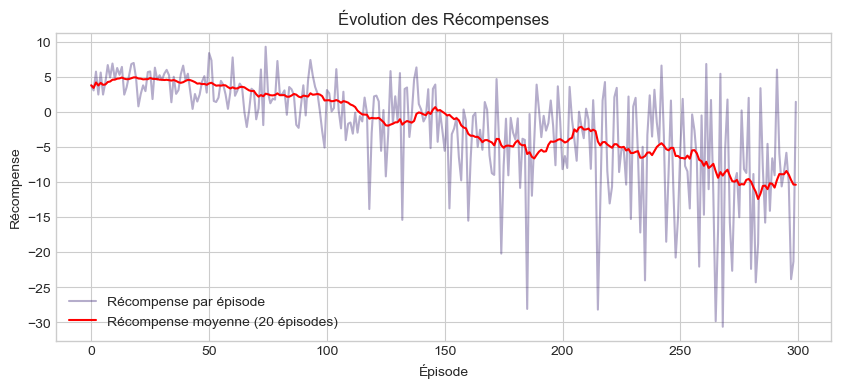

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(rewards, label="Récompense par épisode", alpha=0.4)
plt.plot(avg_rewards, label="Récompense moyenne (20 épisodes)", color='red')
plt.title("Évolution des Récompenses")
plt.xlabel("Épisode")
plt.ylabel("Récompense")
plt.legend()
plt.grid(True)
plt.show()


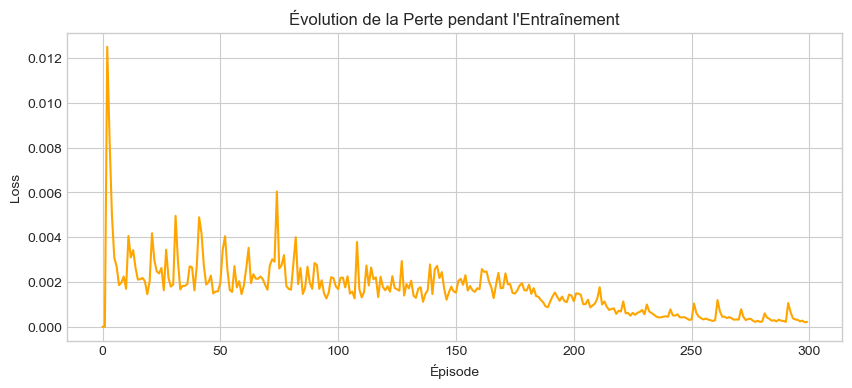

In [49]:
plt.figure(figsize=(10, 4))
plt.plot(losses, label="Perte moyenne", color='orange')
plt.title("Évolution de la Perte pendant l'Entraînement")
plt.xlabel("Épisode")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [50]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Reward
axs[0].plot(rewards, label='Récompense', alpha=0.4)
axs[0].plot(avg_rewards, label='Moyenne (20)', color='red')
axs[0].set_title("Récompense par épisode")
axs[0].set_ylabel("Reward")
axs[0].legend()
axs[0].grid(True)

# Epsilon
axs[1].plot(epsilons, label='Epsilon', color='green')
axs[1].set_title("Valeur de Epsilon")
axs[1].set_ylabel("Epsilon")
axs[1].grid(True)

# Loss
axs[2].plot(losses, label='Perte', color='orange')
axs[2].set_title("Perte moyenne par épisode")
axs[2].set_xlabel("Épisodes")
axs[2].set_ylabel("Loss")
axs[2].grid(True)

plt.tight_layout()
plt.show()


NameError: name 'epsilons' is not defined